<a id=contents></a>

# Exploring differences in salary between Data Scientists, Analysts and Machine Learning Engineers



[1. Exploratory data analysis](#one)

[2. Selecting a statistical test](#stat)

[3. Summary of findings](#conc)

In [56]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pt
import plotly_express as px

from scipy import stats


%matplotlib inline
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

import functions as fn
import stats_tests as st

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=one ><a/> 

# 1. EDA 
    
[LINK to table of contents](#contents)

Please note that this data is "from the wild" - it was webscraped in a period between March and June of 2020 with 3 separate searches. The number of jobs varies between the 3 categories, naturally, and there are several key assumptions in our data collection that we must take note of:

1. Data posts off indeed.co.uk in this period are representative of the respective jobs across the London market;
2. The posts were scraped in the order that they came up in the search (which was ordered by decreasing 'relevance', where the relevance was decided by the website indeed.co.uk) - we're assuming that the most pertinent posts came up first
**3. Searches for one category invariably brings up results for another in the mix: if I search "data scientist", amongst the searches I will get results for "analyst" and "MLEng" jobs as well. This is a crucial point to note that there categories overlap - that is not to say there are duplicates, as these were removed. If we wanted to be more strict in our search we could use regex to trim the categories via job title using regex. However, I have reasoned that the reason for the results coming up mixed is more a reflection of the blurry lines between the roles. Thus, if we go forward with the assumption that whenever we are referring to a "DS" job, we are actually referring to a "searched for DS" job, then we retain a crucial detail. After all, if this information is to be useful for job searchers, we're trying to compare whether a job searcher should directly type in "data scientist" or "data analyst" or "machine learning engineer". From that perpective, our investigation remains valid.**

Notes on preprocessing: In a previous notebook (4b_Data_preprocessing.ipynb) I had done the following:
* extracted salary and salary ranges via regex from the description of the job
* where a range was given, I averaged
* with multiple intervals given for salary, I produced an additional column, where salary was stated per hour
* there is also an additional column stating what time interval was  given (e.g. Y - year; w - week), in case you'd want to use different sections of the data.

In [5]:
# load our data
df = pd.read_csv('clean_data/salary_data.csv', index_col=0)

How many jobs actually advertise their salary? If our data is representative, then this is not a pretty sight:


In [18]:
df.searched__data_analyst.value_counts()[1]

986

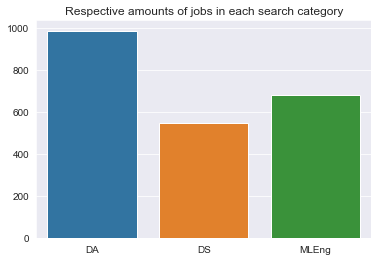

In [22]:
sns.barplot(x = ['DA', 'DS', 'MLEng'], 
            y = [df.searched__data_analyst.value_counts()[1],
                 df.searched__data_scientist.value_counts()[1],
                 df.searched__machine_learning_engineer.value_counts()[1]]);
plt.title('Respective amounts of jobs in each search category');

In [6]:
print('The percentage of jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna()])/len(df),2)))

The percentage of jobs in our sample that openly state any kind of salary range is 38.31


In [8]:
print('The absolute nr of DS jobs in our sample that openly state any kind of salary range is     {}'.format((len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__data_scientist==1]))))
print('The absolute nr of DA jobs in our sample that openly state any kind of salary range is     {}'.format((len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__data_analyst==1]))))
print('The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__machine_learning_engineer==1])))

The absolute nr of DS jobs in our sample that openly state any kind of salary range is     202
The absolute nr of DA jobs in our sample that openly state any kind of salary range is     426
The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is 219


In [9]:
print('The percentage of DS jobs in our sample that openly state any kind of salary range is     {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__data_scientist==1])/len(df.loc[df.searched__data_scientist==1]),2)))
print('The percentage of DA jobs in our sample that openly state any kind of salary range is     {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__data_analyst==1])/len(df.loc[df.searched__data_analyst==1]),2)))
print('The percentage of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna() & df.searched__machine_learning_engineer==1])/len(df.loc[df.searched__machine_learning_engineer==1]),2)))

The percentage of DS jobs in our sample that openly state any kind of salary range is     37.06
The percentage of DA jobs in our sample that openly state any kind of salary range is     43.2
The percentage of ML Eng jobs in our sample that openly state any kind of salary range is 32.21


In [27]:
df.salary_from_page_source_time_period.value_counts(True)

Y    0.858156
D    0.111111
W    0.020095
H    0.008274
M    0.002364
Name: salary_from_page_source_time_period, dtype: float64

In [23]:
df.loc[df.searched__data_scientist==1].salary_from_page_source_time_period.value_counts(True)

Y    0.900990
D    0.059406
W    0.024752
H    0.009901
M    0.004950
Name: salary_from_page_source_time_period, dtype: float64

In [28]:
df.loc[df.searched__data_analyst==1].salary_from_page_source_time_period.value_counts(True)

Y    0.807512
D    0.161972
W    0.016432
H    0.011737
M    0.002347
Name: salary_from_page_source_time_period, dtype: float64

In [29]:
df.loc[df.searched__machine_learning_engineer==1].salary_from_page_source_time_period.value_counts(True)

Y    0.917431
D    0.059633
W    0.022936
Name: salary_from_page_source_time_period, dtype: float64

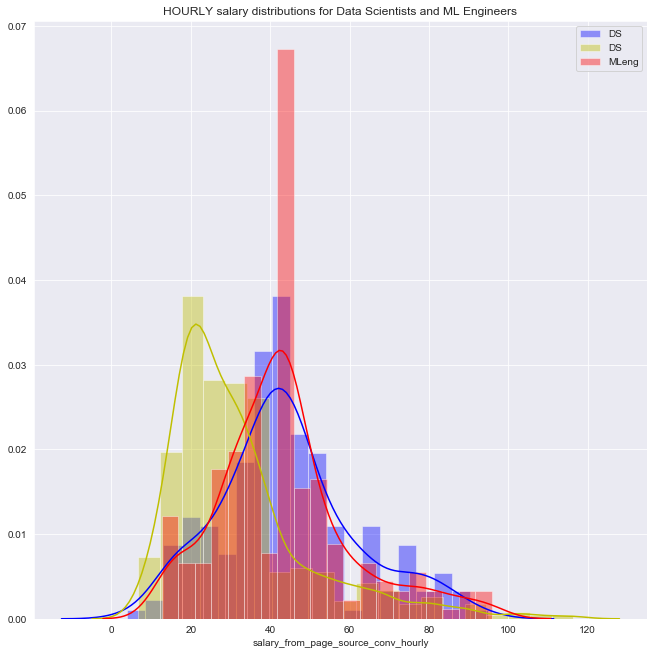

In [30]:
plt.figure(figsize=(11,11))
sns.distplot(df.loc[df['searched__data_scientist']==1].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(df.loc[df['searched__data_analyst']==1].salary_from_page_source_conv_hourly, color='y', label='DS', bins=20)
sns.distplot(df.loc[df['searched__machine_learning_engineer']==1].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.title('HOURLY salary distributions for Data Scientists and ML Engineers')
plt.legend()
plt.savefig('fig/salary_per_hour.jpeg')
plt.show();

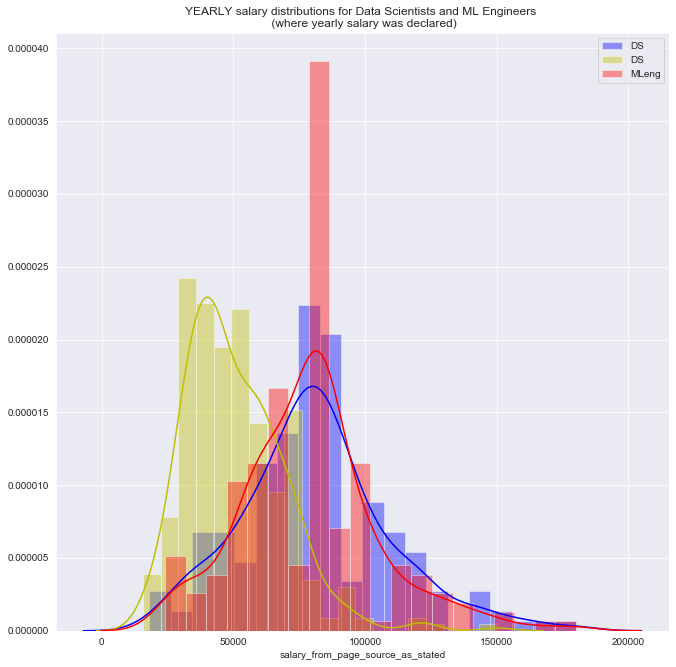

In [33]:
plt.figure(figsize=(11,11))
sns.distplot(df.loc[((df['searched__data_scientist']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_as_stated, color='b', label='DS', bins=20)
sns.distplot(df.loc[((df['searched__data_analyst']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_as_stated, color='y', label='DS', bins=20)
sns.distplot(df.loc[((df['searched__machine_learning_engineer']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_as_stated, color='r', label='MLeng', bins=20)
plt.title('YEARLY salary distributions for Data Scientists and ML Engineers \n (where yearly salary was declared)')
plt.legend()
plt.savefig('fig/yearly_salary_dist.jpeg')
plt.show();

<a id=stat ><a/> 

# 2. Selecting a statistical test
    
[LINK to table of contents](#contents)

    
A great deal of statistical tests rely on assumptions about normality and the equality of the variances between distributions. Below we quickly inspect the distributions and run these tests before deciding on how to compare the salaries. 
    * separate our relevant data - we'll take yearly declared salary as the steps that lead to the acquisition of this data are fewer in number and thus fewer assumptions have been made regarding accuracy
    * checking for measures of dispersion
    * running normality test

In [39]:
salary_df = df.loc[df.salary_from_page_source_time_period=='Y'].drop(columns=['salary_from_page_source_conv_hourly', 'salary_from_page_source_time_period'])
#data analyst data
da_df = salary_df.loc[salary_df.searched__data_analyst==1].drop(columns=['searched__data_analyst','searched__data_scientist', 'searched__machine_learning_engineer'])
# data scientist data
ds_df = salary_df.loc[salary_df.searched__data_scientist==1].drop(columns=['searched__data_analyst','searched__data_scientist', 'searched__machine_learning_engineer'])
# ml engineer data
me_df = salary_df.loc[salary_df.searched__machine_learning_engineer==1].drop(columns=['searched__data_analyst','searched__data_scientist', 'searched__machine_learning_engineer'])

Looking at the measures of dispersion (mean, standard deviation and median) we have good reason to believe that the at least the DA data is relatively normal. The other two datasets are not necessarily far off, given the median and mode being equal for both. The distributions are affected greatly by the outliers (there's a DA job paying £150'000 apparently! That certainly defied my expectations). 

MODE:  45000.0


,salary_from_page_source_as_stated
count,344.000000
mean,50405.747093
std,18829.658275
min,15600.000000
25%,36000.000000
50%,45000.000000
75%,60000.000000
max,150000.000000


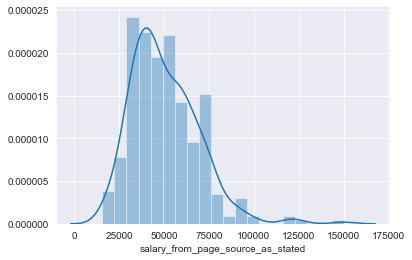

In [52]:
print("MODE: ", da_df.salary_from_page_source_as_stated.mode()[0])
sns.distplot(da_df.salary_from_page_source_as_stated, )
da_df.describe()

MODE:  80000.0


,salary_from_page_source_as_stated
count,182.000000
mean,81211.307692
std,28409.499262
min,18000.000000
25%,65000.000000
50%,80000.000000
75%,95000.000000
max,180000.000000


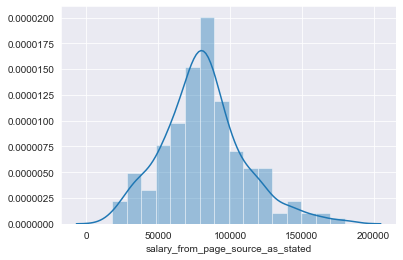

In [53]:
print("MODE: ", ds_df.salary_from_page_source_as_stated.mode()[0])
sns.distplot(ds_df.salary_from_page_source_as_stated, )
ds_df.describe()

MODE:  80000.0


,salary_from_page_source_as_stated
count,200.000000
mean,79084.610000
std,25986.409376
min,24000.000000
25%,60000.000000
50%,80000.000000
75%,90000.000000
max,180000.000000


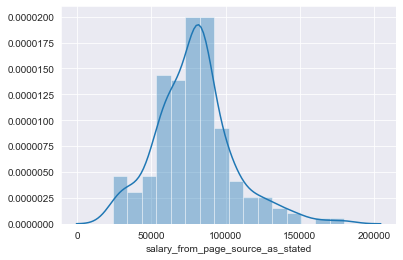

In [54]:
print("MODE: ", me_df.salary_from_page_source_as_stated.mode()[0])
sns.distplot(me_df.salary_from_page_source_as_stated, )
me_df.describe()

We will perform the normality test on our data, using the scipy.stats package. We're setting our alpha across the board to be 0.05 for all tests. 
Our sample sizes are around between 180 and 345, which is a moderate amount of data points. Since the Shapiro-Wilks test can be sensitive to outliers, we'll also display QQ plots. 


In [79]:
from statsmodels.graphics.gofplots import qqplot as sm_qq


p-value is  5.103827430130714e-11
The null hypothesis can be rejected


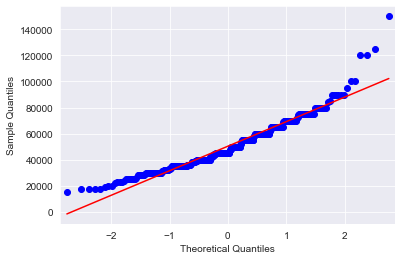

In [85]:
alpha = 0.05
da_dist = da_df.salary_from_page_source_as_stated.values

statistic, p_val_da = st.normality_test(da_dist, alpha)

sm_qq(da_dist, line='s');

p-value is  0.0021711522713303566
The null hypothesis can be rejected


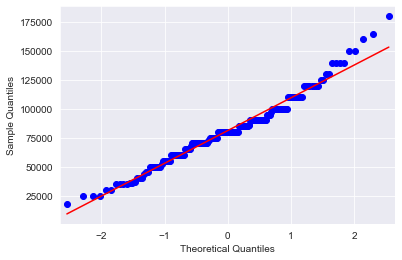

In [86]:
alpha = 0.05
ds_dist = ds_df.salary_from_page_source_as_stated.values

statistic, p_val_ds = st.normality_test(ds_dist, alpha)
sm_qq(ds_dist, line='s');

p-value is  1.4980233572714496e-05
The null hypothesis can be rejected


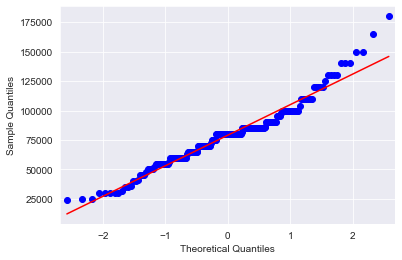

In [87]:
alpha = 0.05
me_dist = me_df.salary_from_page_source_as_stated.values

statistic, p_val_me = st.normality_test(me_dist, alpha)
sm_qq(me_dist, line='s');

Both the test and graphical inspection reveal to us that our distributions are not normal. If we're hoping to use a test like an ANOVA (ANalysis Of VAriance), then we need to rectify our data, by whatever means. At this stage we have the following options: 
* subsample our data till we have a normal distribution
* create a distribution of sample means, using Central Limit Theorem. As we take more and more samples from our data and average them, the distribution of our sample means will converge on a normal distribution.

We will using Central Limit theorem to achieve normal distribution. 

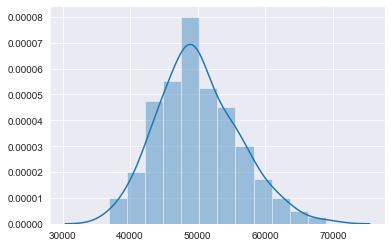

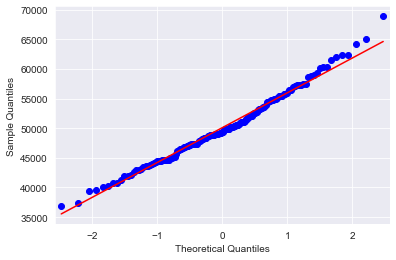

In [131]:
da_dist_sample_means = st.gen_dist_sample_means(da_dist, 150, 10)
sns.distplot(da_dist_sample_means)
sm_qq(da_dist_sample_means, line='s');
plt.ttie

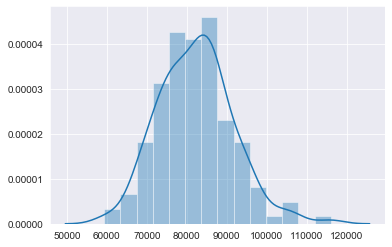

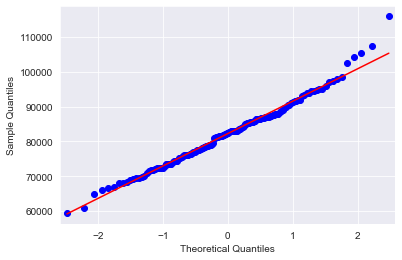

In [132]:
ds_dist_sample_means = st.gen_dist_sample_means(ds_dist, 150, 10)
sns.distplot(ds_dist_sample_means)
sm_qq(ds_dist_sample_means, line='s');

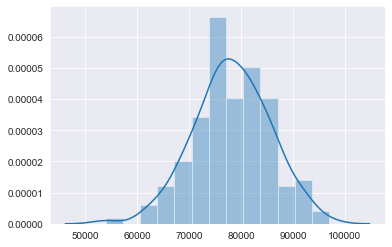

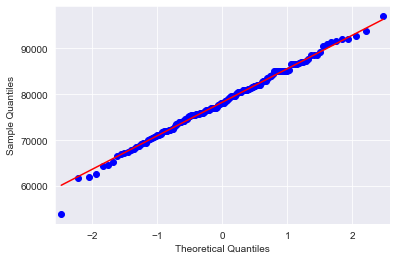

In [133]:
me_dist_sample_means = st.gen_dist_sample_means(me_dist, 150, 10)
sns.distplot(me_dist_sample_means)
sm_qq(me_dist_sample_means, line='s');

In [136]:
print('Data analyst distribution')
st.normality_test(da_dist_sample_means, 0.05);

print('Data scientist distribution')
st.normality_test(ds_dist_sample_means, 0.05);

print('ML Engineer distribution')
st.normality_test(me_dist_sample_means, 0.05);

Data analyst distribution
p-value is  0.16558659076690674
The null hypothesis cannot be rejected
Data scientist distribution
p-value is  0.17227162420749664
The null hypothesis cannot be rejected
ML Engineer distribution
p-value is  0.9185558557510376
The null hypothesis cannot be rejected


<a id=conc ><a/> 

# 3. Summary of findings
    
[LINK to table of contents](#contents)
